<a href="https://colab.research.google.com/github/Dipali-Attarde/InfraBot/blob/master/HR_Analytics_Project_Solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# Import required library
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import xgboost as xgb
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
prj_path = "/content/drive/My Drive/HR_Analytics/"

### Load the dataset 

In [4]:
# Read the required data
df = pd.read_csv(prj_path+'train_LZdllcl.csv')
#print(df.head())
df.head()

,employee_id,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,is_promoted
0,65438,Sales & Marketing,region_7,Master's & above,f,sourcing,1,35,5.0,8,1,0,49,0
1,65141,Operations,region_22,Bachelor's,m,other,1,30,5.0,4,0,0,60,0
2,7513,Sales & Marketing,region_19,Bachelor's,m,sourcing,1,34,3.0,7,0,0,50,0
3,2542,Sales & Marketing,region_23,Bachelor's,m,other,2,39,1.0,10,0,0,50,0
4,48945,Technology,region_26,Bachelor's,m,other,1,45,3.0,2,0,0,73,0


#Attribute Information:

employee_id - Unique ID for employee
department - Department of employee
region - Region of employment (unordered)
education -	Education Level
gender -	Gender of Employee
recruitment_channel -	Channel of recruitment for employee
no_of_trainings -	no of other trainings completed in previous year on soft skills, technical skills etc.
age -	Age of Employee
previous_year_rating - Employee Rating for the previous year
length_of_service -	Length of service in years
KPIs_met >80% -	if Percent of KPIs(Key performance Indicators) >80% then 1 else 0
awards_won? -	if awards won during previous year then 1 else 0
avg_training_score -	Average score in current training evaluations
is_promoted -	(Target) Recommended for promotion

### EDA 

In [5]:
df.info()
print(df.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54808 entries, 0 to 54807
Data columns (total 14 columns):
employee_id             54808 non-null int64
department              54808 non-null object
region                  54808 non-null object
education               52399 non-null object
gender                  54808 non-null object
recruitment_channel     54808 non-null object
no_of_trainings         54808 non-null int64
age                     54808 non-null int64
previous_year_rating    50684 non-null float64
length_of_service       54808 non-null int64
KPIs_met >80%           54808 non-null int64
awards_won?             54808 non-null int64
avg_training_score      54808 non-null int64
is_promoted             54808 non-null int64
dtypes: float64(1), int64(8), object(5)
memory usage: 5.9+ MB
(54808, 14)


In [6]:
# is_promoted will be dependent variable, check it's distribution
df.groupby(['is_promoted']).size()
# Most of the employees are in not promoted category

is_promoted
0    50140
1     4668
dtype: int64

In [0]:
df.groupby(['education']).size()

education
Bachelor's          36669
Below Secondary       805
Master's & above    14925
dtype: int64

In [0]:
df['previous_year_rating'].describe()

count    50684.000000
mean         3.329256
std          1.259993
min          1.000000
25%          3.000000
50%          3.000000
75%          4.000000
max          5.000000
Name: previous_year_rating, dtype: float64

In [0]:
df['education'].describe()

count          52399
unique             3
top       Bachelor's
freq           36669
Name: education, dtype: object

In [0]:
# Check for missing values
df.isnull().values.any()

True

In [0]:
print(df.isnull().sum())

employee_id                0
department                 0
region                     0
education               2409
gender                     0
recruitment_channel        0
no_of_trainings            0
age                        0
previous_year_rating    4124
length_of_service          0
KPIs_met >80%              0
awards_won?                0
avg_training_score         0
is_promoted                0
dtype: int64


In [0]:
## Filling missing enteris with maximum occuring event
df['previous_year_rating'].fillna(3.0, inplace=True)
df['education'].fillna('Bachelor\'s', inplace=True)

In [8]:
print(df.isnull().sum())

employee_id             0
department              0
region                  0
education               0
gender                  0
recruitment_channel     0
no_of_trainings         0
age                     0
previous_year_rating    0
length_of_service       0
KPIs_met >80%           0
awards_won?             0
avg_training_score      0
is_promoted             0
dtype: int64


In [0]:
# The following code loops through each column and checks if the column type is object then converts those columns
# into categorical with each distinct value becoming a category or code.

for feature in df.columns: # Loop through all columns in the dataframe
    if df[feature].dtype == 'object': # Only apply for columns with categorical strings
        df[feature] = pd.Categorical(df[feature]).codes # Replace strings with an integer

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54808 entries, 0 to 54807
Data columns (total 14 columns):
employee_id             54808 non-null int64
department              54808 non-null int8
region                  54808 non-null int8
education               54808 non-null int8
gender                  54808 non-null int8
recruitment_channel     54808 non-null int8
no_of_trainings         54808 non-null int64
age                     54808 non-null int64
previous_year_rating    54808 non-null float64
length_of_service       54808 non-null int64
KPIs_met >80%           54808 non-null int64
awards_won?             54808 non-null int64
avg_training_score      54808 non-null int64
is_promoted             54808 non-null int64
dtypes: float64(1), int64(8), int8(5)
memory usage: 4.0 MB


In [0]:
# Check Summary Statistics
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
employee_id,54808.0,39195.830627,22586.581449,1.0,19669.75,39225.5,58730.5,78298.0
department,54808.0,4.972796,2.506046,0.0,4.00,5.0,7.0,8.0
region,54808.0,15.428970,8.764954,0.0,11.00,14.0,21.0,33.0
education,54808.0,0.559316,0.889452,0.0,0.00,0.0,2.0,2.0
gender,54808.0,0.702379,0.457216,0.0,0.00,1.0,1.0,1.0
recruitment_channel,54808.0,0.868158,0.980713,0.0,0.00,0.0,2.0,2.0
no_of_trainings,54808.0,1.253011,0.609264,1.0,1.00,1.0,1.0,10.0
age,54808.0,34.803915,7.660169,20.0,29.00,33.0,39.0,60.0
previous_year_rating,54808.0,3.304481,1.214770,1.0,3.00,3.0,4.0,5.0
length_of_service,54808.0,5.865512,4.265094,1.0,3.00,5.0,7.0,37.0


### MDVP:Fo(Hz), MDVP:Fhi(Hz), MDVP:Flo(Hz), MDVP:PPQ, MDVP:RAP, MDVP:shimmer(dB) Mean and 50% values are not similar, seems outlier present
### MDVP:Fo(Hz), MDVP:Fhi(Hz), MDVP:Flo(Hz): It's not normal data by distribution, most of the observations are spread more than 3 standard deviations on each side of the mean.

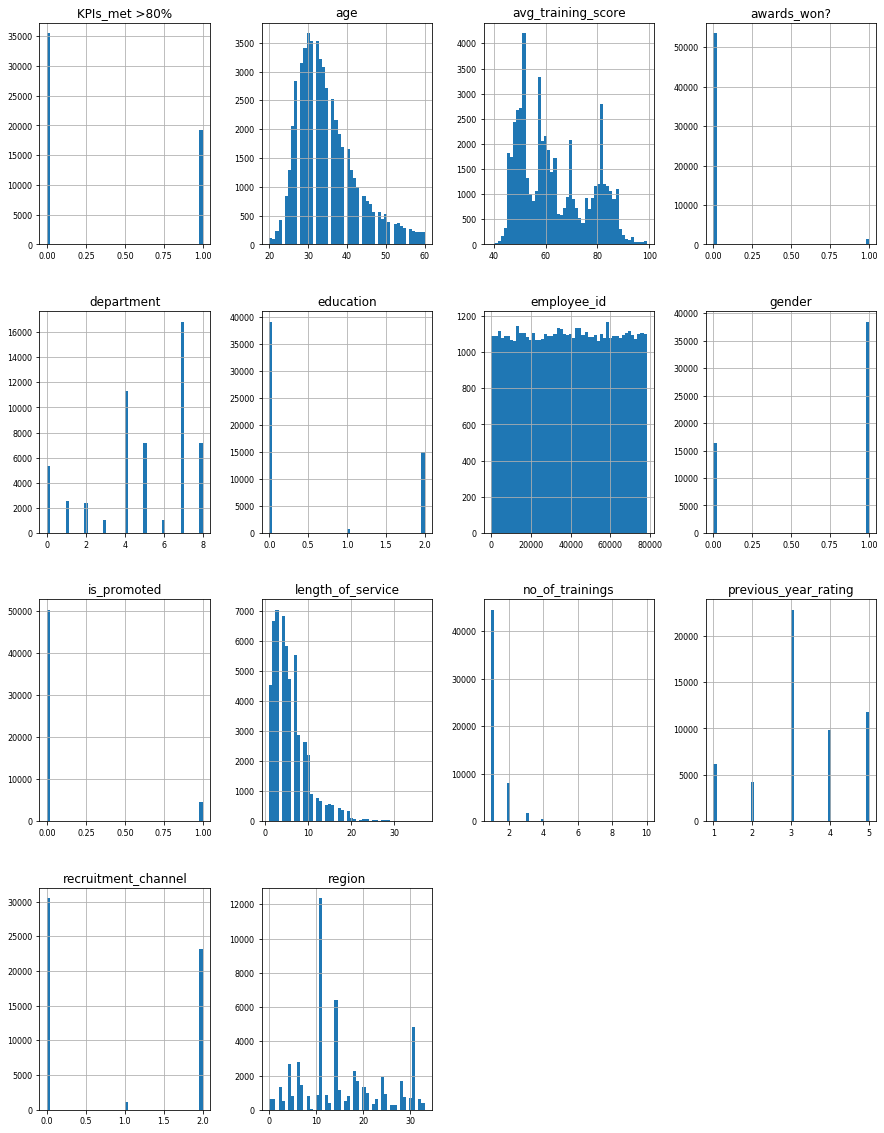

In [0]:
# Plot the distribution for each variable
df.hist(figsize=(15,20),bins = 50,xlabelsize=8,ylabelsize =8)
plt.show()

MDVP:Fhi(Hz): Distribution is right-skewed as mean is greater than the median and there seems several outliers in the data 

MDVP:PPQ, MDVP:RAP, MDVP:shimmer(dB) : Distribution is right-skewed and there seems several outliers in the data

Spread1, Spread2 : Distribution seems uniform 

### Univariate & Bivariate Analysis

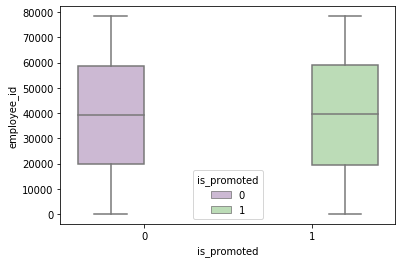

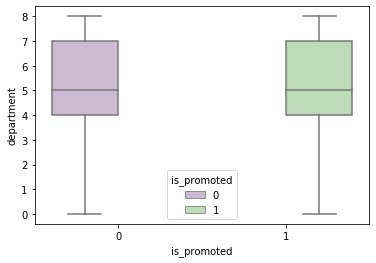

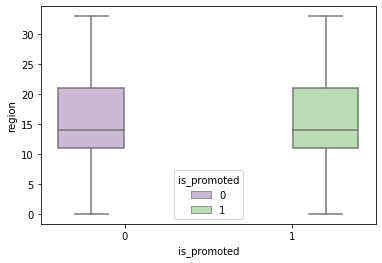

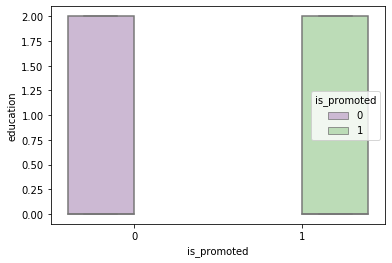

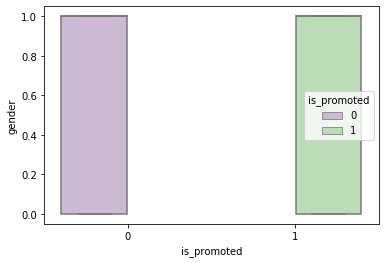

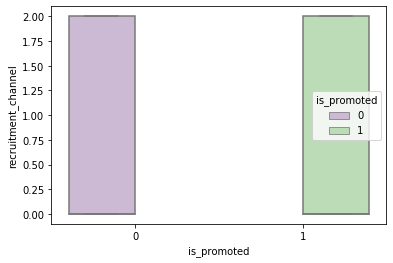

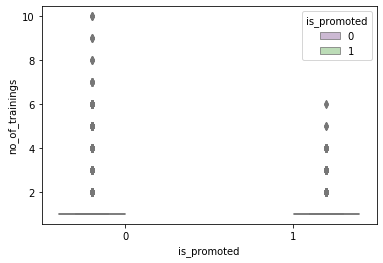

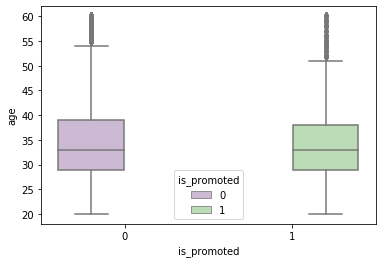

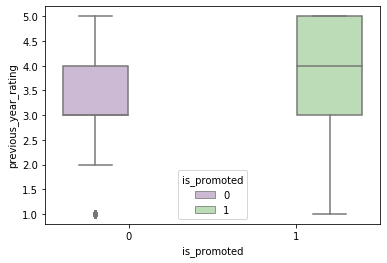

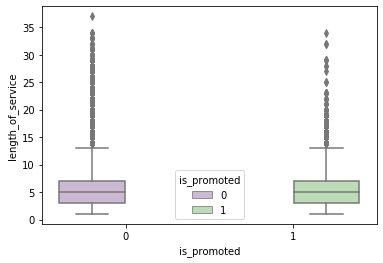

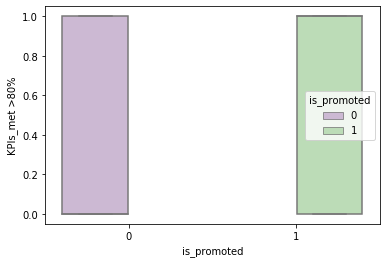

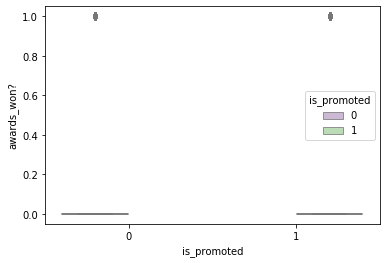

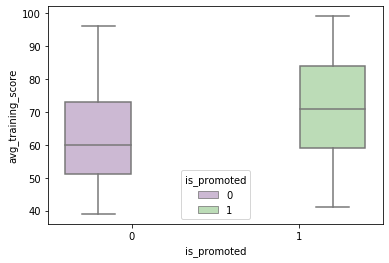

In [0]:
sns.boxplot(x="is_promoted", y="employee_id", hue="is_promoted", data=df, palette="PRGn")
plt.show()

sns.boxplot(x="is_promoted", y="department", hue="is_promoted", data=df, palette="PRGn")
plt.show()

sns.boxplot(x="is_promoted", y="region", hue="is_promoted", data=df, palette="PRGn")
plt.show()

sns.boxplot(x="is_promoted", y="education", hue="is_promoted", data=df, palette="PRGn")
plt.show()

sns.boxplot(x="is_promoted", y="gender", hue="is_promoted", data=df, palette="PRGn")
plt.show()

sns.boxplot(x="is_promoted", y="recruitment_channel", hue="is_promoted", data=df, palette="PRGn")
plt.show()

sns.boxplot(x="is_promoted", y="no_of_trainings", hue="is_promoted", data=df, palette="PRGn")
plt.show()

sns.boxplot(x="is_promoted", y="age", hue="is_promoted", data=df, palette="PRGn")
plt.show()

sns.boxplot(x="is_promoted", y="previous_year_rating", hue="is_promoted", data=df, palette="PRGn")
plt.show()

sns.boxplot(x="is_promoted", y="length_of_service", hue="is_promoted", data=df, palette="PRGn")
plt.show()

sns.boxplot(x="is_promoted", y="KPIs_met >80%", hue="is_promoted", data=df, palette="PRGn")
plt.show()

sns.boxplot(x="is_promoted", y="awards_won?", hue="is_promoted", data=df, palette="PRGn")
plt.show()

sns.boxplot(x="is_promoted", y="avg_training_score", hue="is_promoted", data=df, palette="PRGn")
plt.show()

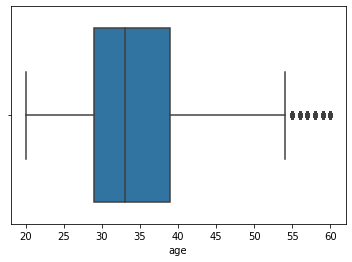

In [0]:
sns.boxplot(x=df['age'])

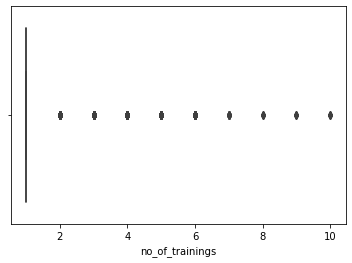

In [0]:
sns.boxplot(x=df['no_of_trainings'])

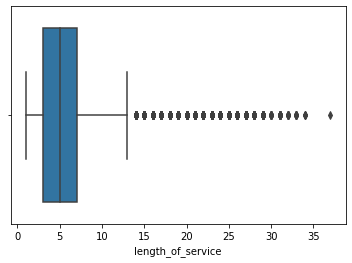

In [0]:
sns.boxplot(x=df['length_of_service'])

,employee_id,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,is_promoted
employee_id,1.000000,-0.005187,-0.003423,0.002124,-0.001542,0.005960,-0.005121,0.000437,0.004209,0.001274,-0.002501,0.008420,-0.000586,0.001206
department,-0.005187,1.000000,-0.020592,0.043441,-0.030108,0.004732,0.014152,0.079162,-0.135561,0.059060,-0.088209,-0.002151,-0.251626,0.000130
region,-0.003423,-0.020592,1.000000,-0.003815,0.019730,-0.000920,-0.004590,-0.088918,-0.005977,-0.058939,-0.007664,0.000307,0.023572,0.008841
education,0.002124,0.043441,-0.003815,1.000000,-0.032368,-0.003564,-0.033469,0.339966,0.027393,0.233666,0.012123,-0.001409,0.032787,0.029257
gender,-0.001542,-0.030108,0.019730,-0.032368,1.000000,0.006567,0.084501,-0.016293,-0.024024,-0.019675,-0.037400,0.002381,-0.024494,-0.011109
recruitment_channel,0.005960,0.004732,-0.000920,-0.003564,0.006567,1.000000,-0.010405,-0.011400,0.005731,-0.002887,-0.000297,-0.005510,-0.002416,0.002229
no_of_trainings,-0.005121,0.014152,-0.004590,-0.033469,0.084501,-0.010405,1.000000,-0.081278,-0.061564,-0.057275,-0.045576,-0.007628,0.042517,-0.024896
age,0.000437,0.079162,-0.088918,0.339966,-0.016293,-0.011400,-0.081278,1.000000,0.026810,0.657111,-0.025592,-0.008169,-0.048380,-0.017166
previous_year_rating,0.004209,-0.135561,-0.005977,0.027393,-0.024024,0.005731,-0.061564,0.026810,1.000000,0.023504,0.337367,0.026587,0.071926,0.153230
length_of_service,0.001274,0.059060,-0.058939,0.233666,-0.019675,-0.002887,-0.057275,0.657111,0.023504,1.000000,-0.077693,-0.039927,-0.038122,-0.010670


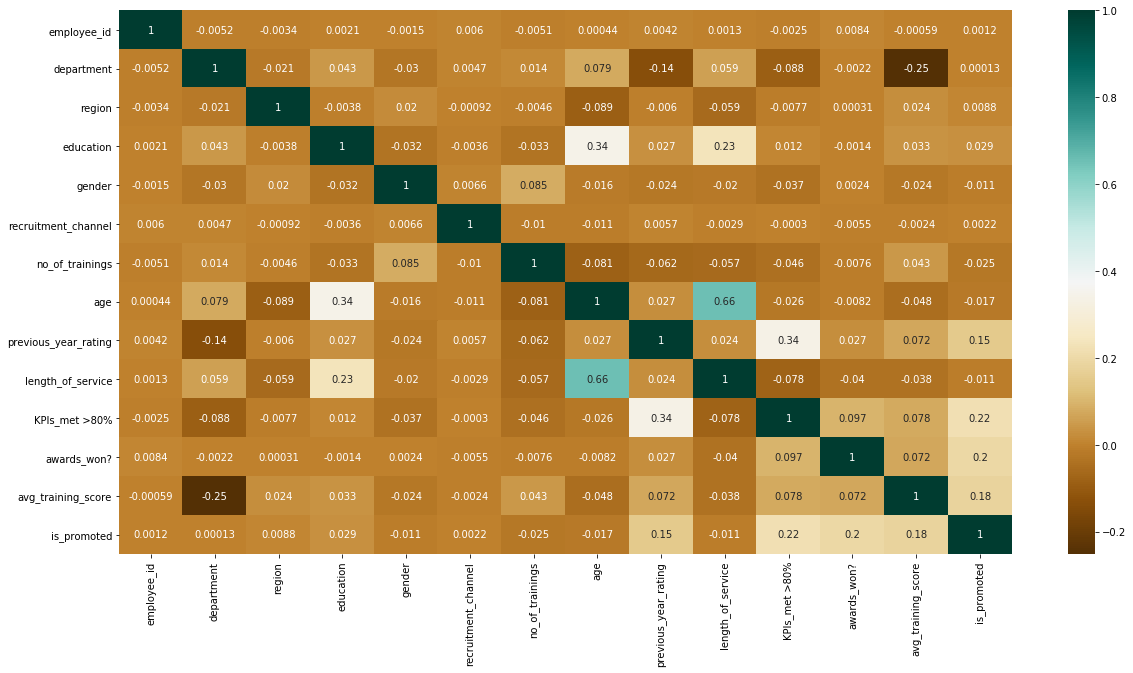

In [0]:
# Finding the relations between the variables.
plt.figure(figsize=(20,10))
c= df.corr()
sns.heatmap(c,cmap='BrBG',annot=True)
c

###  MDVP:Fo(Hz) varies a lot on the upper quartile group which is shown by the long whisker on the upper fence. There are no outliers in the data .
### MDVP:Fhi(Hz) varies a lot on the upper quartile group which is shown by the long whisker on the upper fence. Outliers are present in the data
### MDVP:Flo(Hz) varies a lot on the upper quartile group which is shown by the long whisker on the upper fence. Outliers are present in the data
### MDVP:Jitter(%) varies on the upper quartile group which is shown by the long whisker on the upper fence.Due to most of the datapoints are outliers the median is very low
### MDVP:Jitter(Abs) varies on the upper quartile group. Presence of outliers makes the distribution right-skewed
### MDVP:RAP varies on the upper quartile group especially for status=1 . Due to most of the datapoints are outliers the median is very low 
### NHR data variability/spread is very high and most of the datapoints are outliers . So the IQR is so narrow with median value close to the Q1 value


In [0]:
# Check the correlation
df.corr()

,employee_id,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,is_promoted
employee_id,1.000000,-0.005187,-0.003423,0.002124,-0.001542,0.005960,-0.005121,0.000437,0.004209,0.001274,-0.002501,0.008420,-0.000586,0.001206
department,-0.005187,1.000000,-0.020592,0.043441,-0.030108,0.004732,0.014152,0.079162,-0.135561,0.059060,-0.088209,-0.002151,-0.251626,0.000130
region,-0.003423,-0.020592,1.000000,-0.003815,0.019730,-0.000920,-0.004590,-0.088918,-0.005977,-0.058939,-0.007664,0.000307,0.023572,0.008841
education,0.002124,0.043441,-0.003815,1.000000,-0.032368,-0.003564,-0.033469,0.339966,0.027393,0.233666,0.012123,-0.001409,0.032787,0.029257
gender,-0.001542,-0.030108,0.019730,-0.032368,1.000000,0.006567,0.084501,-0.016293,-0.024024,-0.019675,-0.037400,0.002381,-0.024494,-0.011109
recruitment_channel,0.005960,0.004732,-0.000920,-0.003564,0.006567,1.000000,-0.010405,-0.011400,0.005731,-0.002887,-0.000297,-0.005510,-0.002416,0.002229
no_of_trainings,-0.005121,0.014152,-0.004590,-0.033469,0.084501,-0.010405,1.000000,-0.081278,-0.061564,-0.057275,-0.045576,-0.007628,0.042517,-0.024896
age,0.000437,0.079162,-0.088918,0.339966,-0.016293,-0.011400,-0.081278,1.000000,0.026810,0.657111,-0.025592,-0.008169,-0.048380,-0.017166
previous_year_rating,0.004209,-0.135561,-0.005977,0.027393,-0.024024,0.005731,-0.061564,0.026810,1.000000,0.023504,0.337367,0.026587,0.071926,0.153230
length_of_service,0.001274,0.059060,-0.058939,0.233666,-0.019675,-0.002887,-0.057275,0.657111,0.023504,1.000000,-0.077693,-0.039927,-0.038122,-0.010670


#### There is no strong correlation between any two variables.
### There is no strong correlation between any independent variable and dependent variable.
### MDVP:Fo(Hz),MDVP:Flo(Hz),MDVP:Jitter(Abs),MDVP:Shimmer,MDVP:Shimmer(dB),Shimmer:APQ3,Shimmer:APQ5,MDVP:APQ,Shimmer:DDA,HNR,RPDE,spread1,spread2,D2,PPE have moderate correlation with the target variable - status
### spread1 has a significant correlation with spread2,D2,PPE
### Due to limited domain knowledge, let's not do any treatment for outliers

In [0]:
# Correlation between is_promoted and other independent variables
df.corr()["is_promoted"]

employee_id             0.001206
department              0.000130
region                  0.008841
education               0.029257
gender                 -0.011109
recruitment_channel     0.002229
no_of_trainings        -0.024896
age                    -0.017166
previous_year_rating    0.153230
length_of_service      -0.010670
KPIs_met >80%           0.221582
awards_won?             0.195871
avg_training_score      0.181147
is_promoted             1.000000
Name: is_promoted, dtype: float64

In [0]:
# Making dependent and in dependent variables seperated
X = df.drop('is_promoted', axis=1)
y = df['is_promoted']

In [12]:
X.shape

(54808, 13)

In [13]:
y.shape

(54808,)

### Split dataset into training & test dataset  

In [0]:
# Split the data into training and test set in the ratio of 70:30 respectively
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y,train_size=0.8, random_state=1)

### Create a default decision tree model using criterion = Entropy 

In [15]:
from sklearn.tree import DecisionTreeClassifier
dtc = DecisionTreeClassifier(criterion='entropy')
dtc.fit(X_train,y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [16]:
from sklearn.metrics import accuracy_score
y_predict = dtc.predict(X_test)
accuracy_score(y_test, y_predict)

0.903484765553731

### Model Regularization 

In [0]:
dtc2 = DecisionTreeClassifier(criterion='entropy',max_depth=5, max_leaf_nodes=2)
dtc2.fit(X_train,y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=5, max_features=None, max_leaf_nodes=2,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [0]:
y_predict = dtc2.predict(X_test)
accuracy_score(y_test, y_predict)

0.9139755519065864

In [0]:
dtc3 = DecisionTreeClassifier(criterion='entropy',max_depth=5, max_leaf_nodes=5)
dtc3.fit(X_train,y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=5, max_features=None, max_leaf_nodes=5,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [0]:
y_predict = dtc3.predict(X_test)
accuracy_score(y_test, y_predict)

0.919722678343368

In [0]:
dtc4 = DecisionTreeClassifier(criterion='entropy',max_depth=5, max_leaf_nodes=15)
dtc4.fit(X_train,y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=5, max_features=None, max_leaf_nodes=15,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [0]:
y_predict = dtc4.predict(X_test)
accuracy_score(y_test, y_predict)

0.9239189928845101

In [0]:
from sklearn.metrics import f1_score
f1_score(y_test, y_predict)

0.4476834981780322

As you can see from the above models, the ideal no of leaf nodes is between 10 to 15. The ideal no of leaf_nodes and depth of the tree can be found out by running these model iteratively by tuning the hyperparameters. In the above case, I have showcased how accuracy values change for few cases. 
It would be a right call to use Grid search or ROC curve (which you will be learning later as a part of this program) to find out the optimal hyperparameters. 

### Cross tab & Accuracy of the models 

In [0]:
from sklearn.metrics import confusion_matrix

pd.DataFrame(
    confusion_matrix(y_test, y_predict),
    columns=['Predicted Healthy', 'Predicted Parkinsons'],
    index=['True Healthy', 'True Parkinsons']
)

,Predicted Healthy,Predicted Parkinsons
True Healthy,9970,49
True Parkinsons,785,158


### Random forest classifier

In [0]:
# Use the classification algorithms and compare the models to find the best model
from sklearn.ensemble import RandomForestClassifier

random_forest = RandomForestClassifier()

In [0]:
random_forest.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [0]:
from sklearn.metrics import accuracy_score

y_predict = random_forest.predict(X_test)
accuracy_score(y_test, y_predict)

0.934592227695676

In [0]:
pd.DataFrame(
    confusion_matrix(y_test, y_predict),
    columns=['Predicted Healthy', 'Predicted Parkinsons'],
    index=['True Healthy', 'True Parkinsons']
)

,Predicted Healthy,Predicted Parkinsons
True Healthy,9997,22
True Parkinsons,695,248


In [0]:
from sklearn.metrics import f1_score
f1_score(y_test, y_predict)

0.4089035449299258

In [0]:
model=xgb.XGBClassifier(random_state=1,learning_rate=0.01)
model.fit(X_train, y_train)
model.score(X_test,y_test)

0.9235540959678891

In [0]:
y_predict = model.predict(X_test)
accuracy_score(y_test, y_predict)

0.9235540959678891

In [0]:
from sklearn.metrics import f1_score
f1_score(y_test, y_predict)

0.4500775995861355

In [17]:
###Train the model with the best params
modelXg = xgb.XGBClassifier(learning_rate=0.1, n_estimators=200, max_depth=4, min_child_weight=7, 
                      gamma=0.4,nthread=4, subsample=0.8, colsample_bytree=0.8, objective= 'binary:logistic',scale_pos_weight=3,seed=29)
modelXg.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, gamma=0.4,
              learning_rate=0.1, max_delta_step=0, max_depth=4,
              min_child_weight=7, missing=None, n_estimators=200, n_jobs=1,
              nthread=4, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=3, seed=29,
              silent=None, subsample=0.8, verbosity=1)

In [18]:
y_predict = modelXg.predict(X_test)
accuracy_score(y_test, y_predict)

0.9320379492793286

In [19]:
f1_score(y_test, y_predict)

0.5227418321588725

In [22]:
pd.DataFrame(
    confusion_matrix(y_test, y_predict),
    columns=['Predicted Healthy', 'Predicted Parkinsons'],
    index=['True Healthy', 'True Parkinsons']
)

,Predicted Healthy,Predicted Parkinsons
True Healthy,9809,210
True Parkinsons,535,408


In [0]:
from sklearn.model_selection import GridSearchCV
param_test2b = {
  'min_child_weight':[5,6],
  'max_depth': range(4,10),
  'n_estimators':[250,300],
  'scale_pos_weight':[3,4],
  'colsample_bytree':[0.8,0.9], 
  'subsample':[0.7,0.8],
  'gamma':[0.2,0.4]
    
}
gsearch2b = GridSearchCV(estimator = xgb.XGBClassifier( learning_rate=0.1, n_estimators=150, max_depth=5,
min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
objective= 'binary:logistic', nthread=4, scale_pos_weight=3,seed=27), 
param_grid = param_test2b, scoring='f1',n_jobs=4,iid=False, cv=5)
gsearch2b.fit(X_train, y_train)

In [24]:
print("gsearch2b.best_params_",gsearch2b.best_params_)
print("gsearch2b.best_score_",gsearch2b.best_score_)

gsearch2b.best_params_ {'colsample_bytree': 0.8, 'gamma': 0.2, 'max_depth': 5, 'min_child_weight': 6, 'n_estimators': 300, 'scale_pos_weight': 3, 'subsample': 0.7}
gsearch2b.best_score_ 0.5150667942781559


In [32]:
###Train the model with the best params
modelXg_best = xgb.XGBClassifier(learning_rate=0.1, n_estimators=250, max_depth=5, min_child_weight=6, 
                      gamma=0.2,nthread=4, subsample=0.7, colsample_bytree=0.8, objective= 'binary:logistic',scale_pos_weight=3,seed=29)
modelXg_best.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, gamma=0.2,
              learning_rate=0.1, max_delta_step=0, max_depth=5,
              min_child_weight=6, missing=None, n_estimators=250, n_jobs=1,
              nthread=4, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=3, seed=29,
              silent=None, subsample=0.7, verbosity=1)

In [33]:
y_predict = modelXg_best.predict(X_test)
accuracy_score(y_test, y_predict)

0.9304871373836892

In [34]:
f1_score(y_test, y_predict)

0.5243445692883895